In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline



In [2]:
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input


In [3]:
BASE_DIR = '/Users/Cizal/Downloads/new project/UTKFace/'


In [4]:
image_paths = []
age_labels = []
gender_labels = []

for filename in os.listdir(BASE_DIR):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)


In [5]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()


,image,age,gender
0,/Users/Cizal/Downloads/new project/UTKFace/9_1...,9,1
1,/Users/Cizal/Downloads/new project/UTKFace/36_...,36,0
2,/Users/Cizal/Downloads/new project/UTKFace/86_...,86,1
3,/Users/Cizal/Downloads/new project/UTKFace/26_...,26,1
4,/Users/Cizal/Downloads/new project/UTKFace/1_1...,1,1


In [6]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

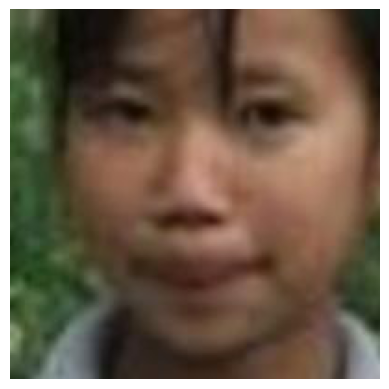

In [7]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

/Users/Cizal/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='age', ylabel='Density'>

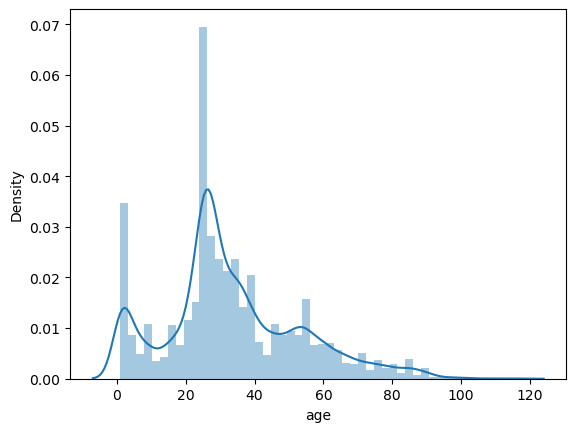

In [8]:
sns.distplot(df['age'])

/Users/Cizal/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: xlabel='gender', ylabel='count'>

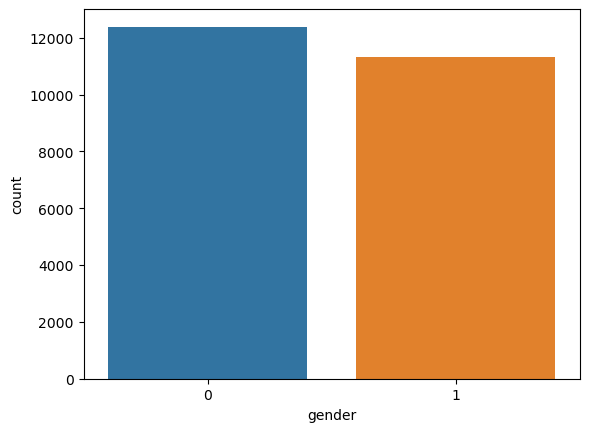

In [9]:
sns.countplot(df['gender'])

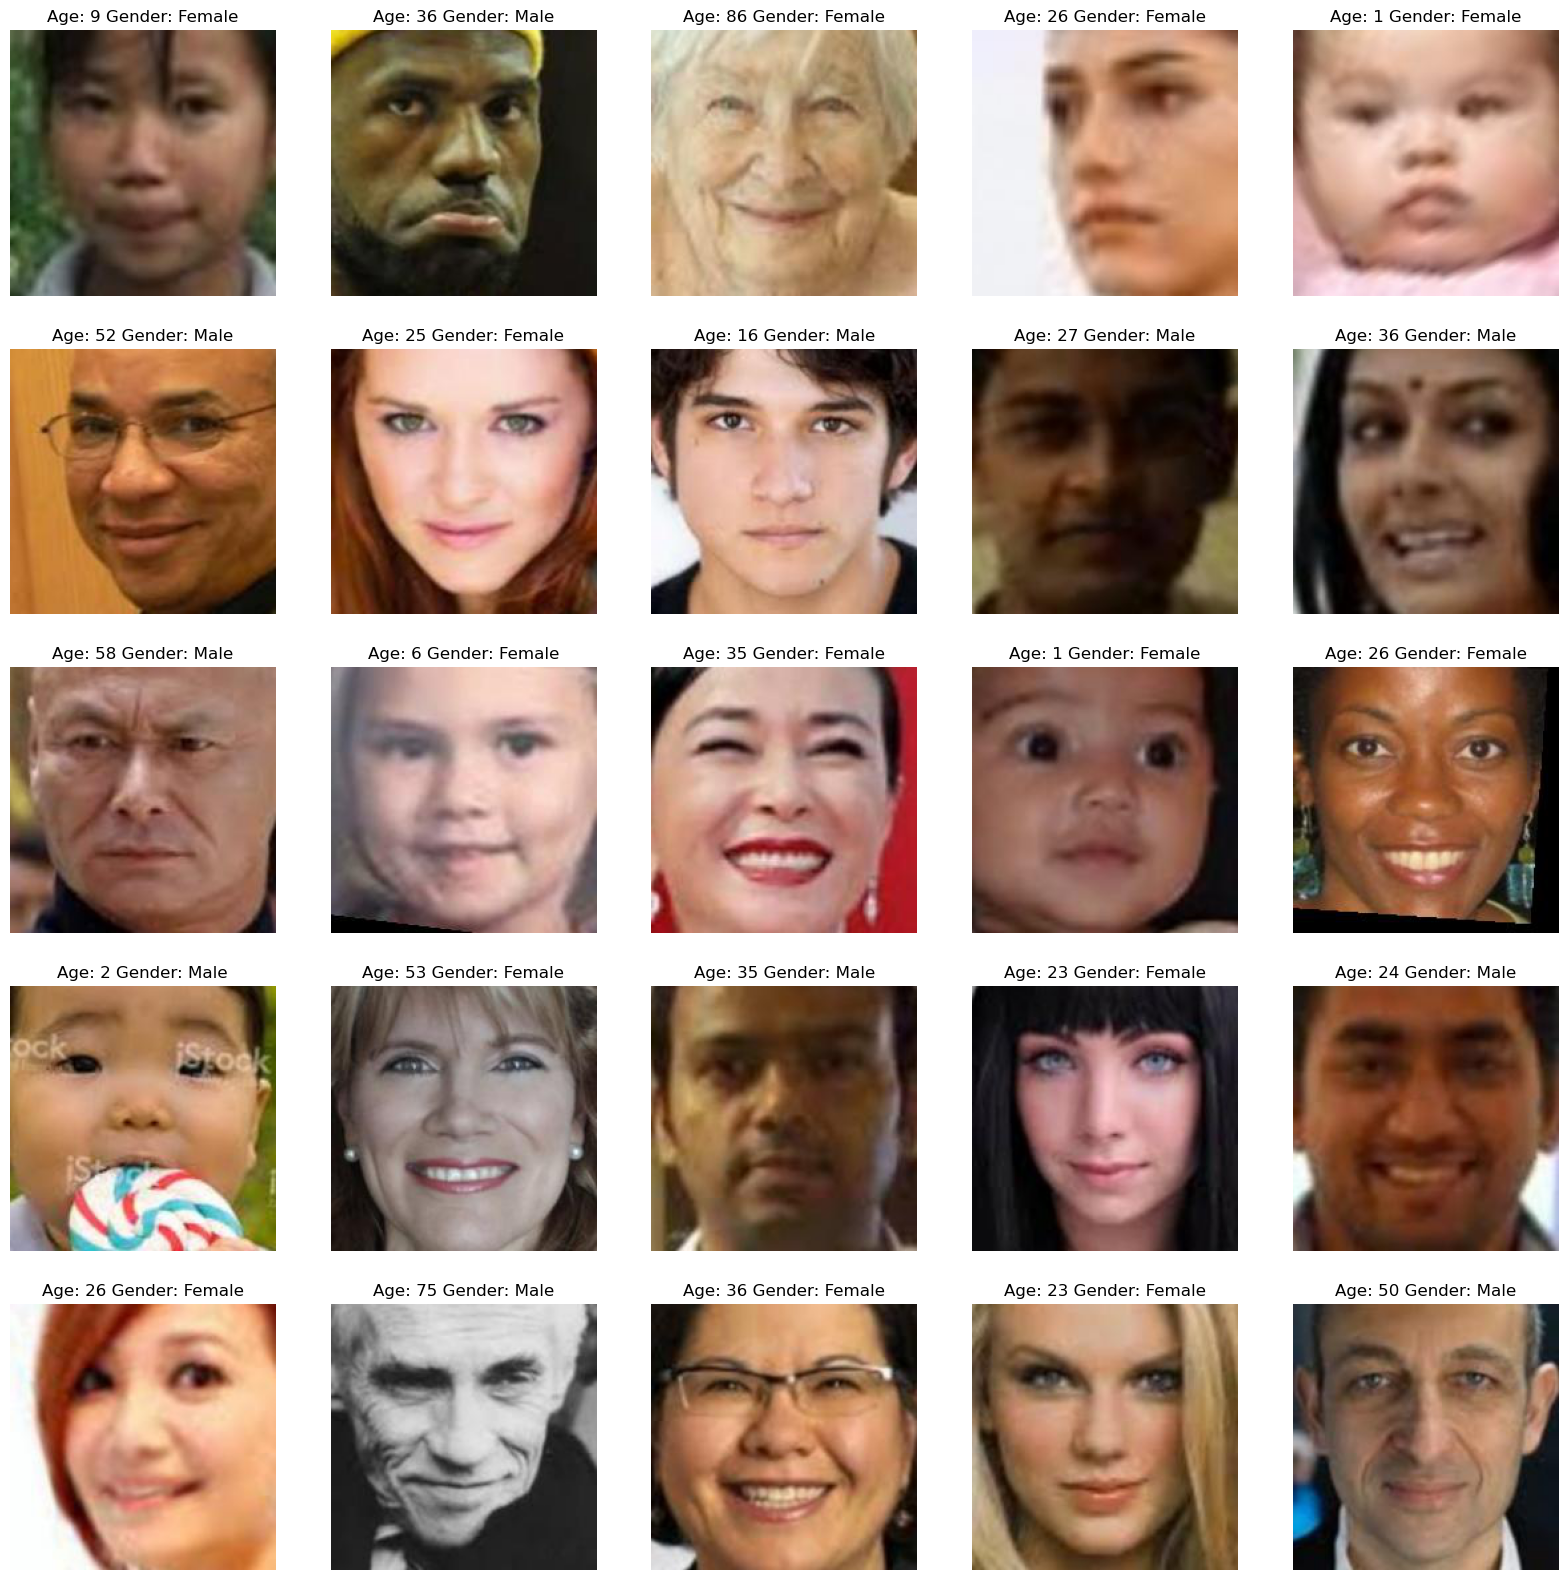

In [10]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [11]:
def extract_features(images):
    features = []
    for image in images:
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features


In [12]:
X = extract_features(df['image'])

/Users/Cizal/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(
/var/folders/yd/3hyn9dln2wd6z4dm_99ltqq00000gn/T/ipykernel_3608/4198809145.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((128, 128), Image.ANTIALIAS)


In [13]:
X.shape

(23708, 128, 128, 1)

In [14]:
# normalize the images
X = X/255.0

In [15]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [16]:
input_shape = (128, 128, 1)

In [24]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='rmsprop', metrics=['accuracy'])


In [25]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 126, 126, 32  320         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 63, 63, 32)  0           ['conv2d_8[0][0]']               
                                                                                            

In [26]:

from tensorflow.keras.utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [27]:
# train model
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20


2022-11-04 13:26:54.996615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


593/593 [==============================] - ETA: 0s - loss: 15.7778 - gender_out_loss: 0.6949 - age_out_loss: 15.0828 - gender_out_accuracy: 0.5967 - age_out_accuracy: 0.0433

2022-11-04 13:27:49.402080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


593/593 [==============================] - 62s 96ms/step - loss: 15.7778 - gender_out_loss: 0.6949 - age_out_loss: 15.0828 - gender_out_accuracy: 0.5967 - age_out_accuracy: 0.0433 - val_loss: 14.2694 - val_gender_out_loss: 0.5151 - val_age_out_loss: 13.7543 - val_gender_out_accuracy: 0.7387 - val_age_out_accuracy: 0.0430
Epoch 2/20
593/593 [==============================] - 54s 91ms/step - loss: 11.4796 - gender_out_loss: 0.4733 - age_out_loss: 11.0062 - gender_out_accuracy: 0.7757 - age_out_accuracy: 0.0207 - val_loss: 9.7654 - val_gender_out_loss: 0.4108 - val_age_out_loss: 9.3546 - val_gender_out_accuracy: 0.8087 - val_age_out_accuracy: 0.0160
Epoch 3/20
593/593 [==============================] - 54s 91ms/step - loss: 9.6311 - gender_out_loss: 0.3834 - age_out_loss: 9.2477 - gender_out_accuracy: 0.8247 - age_out_accuracy: 0.0117 - val_loss: 8.4609 - val_gender_out_loss: 0.3908 - val_age_out_loss: 8.0701 - val_gender_out_accuracy: 0.8026 - val_age_out_accuracy: 0.0049
Epoch 4/20
593/

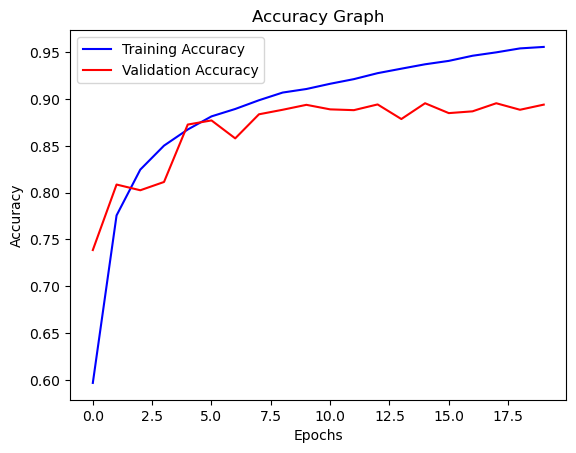

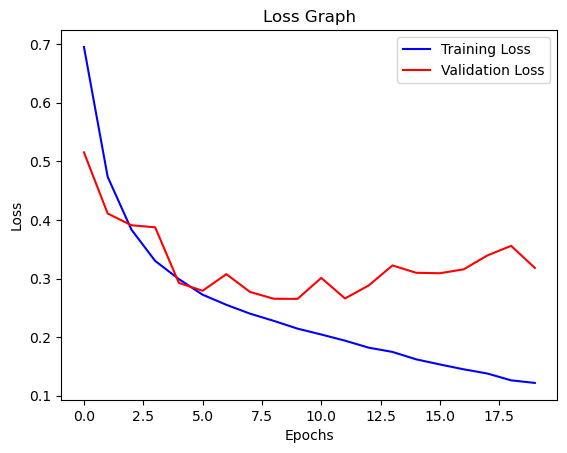

In [29]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


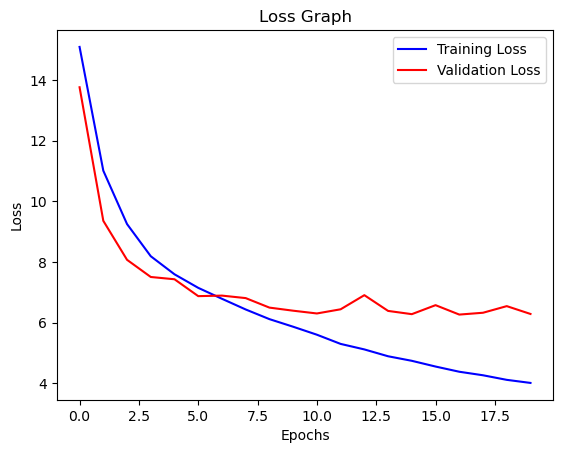

In [30]:
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Original Gender: Male Original Age: 28
1/1 [==============================] - 0s 269ms/step
Predicted Gender: Male Predicted Age: 43


2022-11-04 13:49:54.472376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


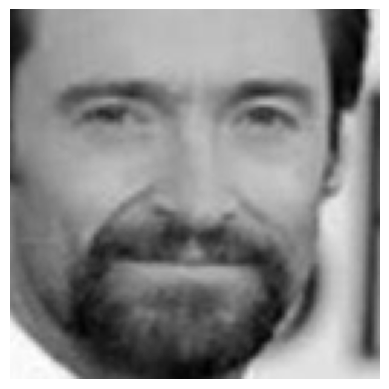

In [31]:
image_index = 500
print("Original Gender:",
      gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');



Original Gender: Female Original Age: 25
1/1 [==============================] - 0s 16ms/step
Predicted Gender: Female Predicted Age: 27


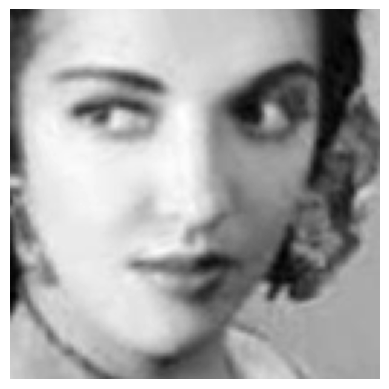

In [35]:
image_index = 4657
print("Original Gender:",
      gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');



Original Gender: Male Original Age: 22
1/1 [==============================] - 0s 10ms/step
Predicted Gender: Male Predicted Age: 25


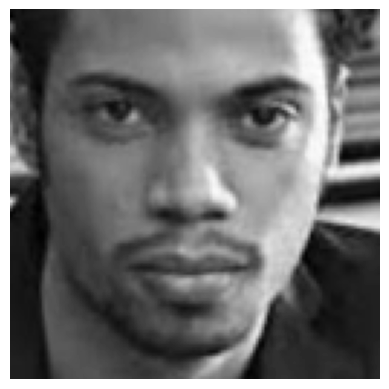

In [37]:
image_index = 29
print("Original Gender:",
      gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
